In [6]:
import numpy as np
from time import time

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize_scalar
from functools import partial

In [7]:
def check_convergence_region(algo, problem, x_0, sigma, iterations=50, size=1000, optimization_problem = True):
    points = np.random.normal(x_0, sigma, size=(size, x_0.shape[0]))
    successes = []
    for point in tqdm(points):
        x_history, values_history, times_history = algo(problem, point, iterations=iterations)
        
        if optimization_problem:
            result = np.min([np.linalg.norm(problem._g.forward(x), ord=2) for x in x_history])
        else:
            result = np.min(values_history)
        if result < 1e-3 / np.sqrt(x0.shape[0]):
            successes.append(1)
        else:
            successes.append(0)
    return points, successes

In [8]:
def draw_plots(values, times, names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    
    for name_, values_ in zip(names, values):
        axs[0].plot(values_, label=name_)
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    
    for name_, times_ in zip(names, times):
        axs[1].plot(times_, label=name_)
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Time, s')
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].legend()
    axs[1].legend()
    
    plt.show()

$5x_i - 5 - \sum\limits_{i = 1}^8 a_{ij} y_j^3 = 0$

First let's compute a

In [9]:
t = np.array([
    0.01985507175123188416,
    0.10166676129318663020,
    0.23734479504183550791,
    0.40828267875217509753,
    0.59171732124782490246,
    0.76276620495816449290,
    0.89333238706813369795,
    0.98014492824876115841,
])

In [10]:
w = np.array([
    0.05061426814518812957,
    0.11119051722668723527,
    0.15685332293894364366,
    0.18134189168918099148,
    0.18134189168918099148,
    0.15685332293894364366,
    0.11119051722668723527,
    0.05061426814518812957,
])

In [11]:
a = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        if (j <= i):
            a[i][j] = w[j] * t[j] * (1 - t[i])
        elif i < j:
            a[i][j] = w[j] * t[i] * (1 - t[j])

Solution: (1.00209, 1.0090, 1.01972, 1.02643, 1.02643, 1.01972, 1.0090, 1.00209)

Initial guess: (0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5)

In [40]:
class HammersteinData():
    def __init__(self, a):
        self._A = a
            
    def forward(self, x):
        
        return 5 * x - 5 - self._A @ x ** 3
        
        
    def grad(self, x):
        return 5 * np.eye(x.shape[0]) - 2 * self._A * np.tile(x ** 2, (8, 1))

In [41]:
class HammersteinDataOptim():
    def __init__(self, g, p = 2):
        self._g = g
        self._p = p
    
    def forward(self, x):
        g = self._g.forward(x)
        return (g ** self._p).sum()
        
    def grad(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x)
        return self._p * grad_g.T @ (g ** (self._p - 1))
    
    def hess(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x) 
        return self._p * (self._p - 1) * grad_g.T @ np.diag(g ** (self._p - 2)) @ grad_g

In [42]:
# equation root 
xi = np.array([1.00209, 1.0090, 1.01972, 1.02643, 1.02643, 1.01972, 1.0090, 1.00209])
# starting point
x0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

## Data initialization

In [43]:
g = HammersteinData(a)
f_2 = HammersteinDataOptim(g, p = 2)
f_4 = HammersteinDataOptim(g, p = 4)
f_6 = HammersteinDataOptim(g, p = 6)

# Newton's Solving algorithm

In [44]:
class NewtonSolvingAlgorithm():
    def __init__(self):
        pass
    
    def solve(self, equation, x0, iterations=10, eps=1e-9):
        x = x0
        x_history = [x]
        values_history = [np.linalg.norm(equation.forward(x), ord=2)]
        times_history = [0]
        
        start = time()
        for i in range(iterations):
            x = x - np.linalg.pinv(equation.grad(x)) @ equation.forward(x)
            
            values_history.append(np.linalg.norm(equation.forward(x), ord=2))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

In [45]:
x_history_ns, values_history_ns, times_history_ns = NewtonSolvingAlgorithm().solve(g, x0, iterations=10)

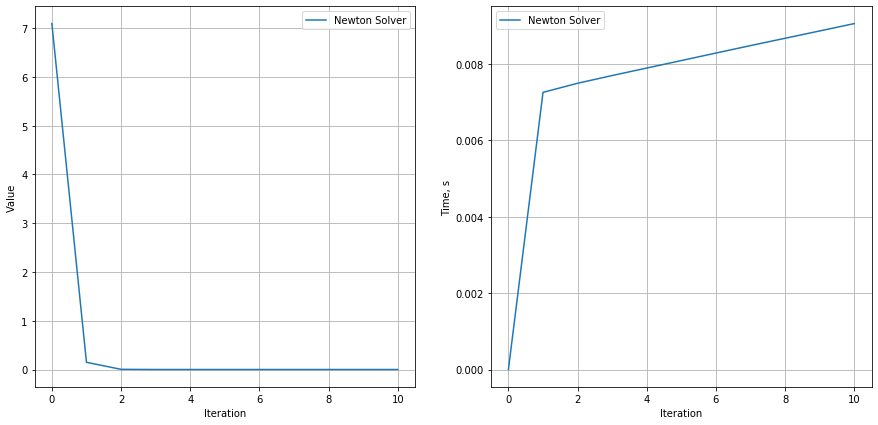

In [46]:
draw_plots([values_history_ns], [times_history_ns], ['Newton Solver'])

In [62]:
points, successes = check_convergence_region(NewtonSolvingAlgorithm().solve, g, x0, 3, size=10000, optimization_problem=False)

In [63]:
(np.array(successes) == 0).sum()

1629

In [64]:
print('Total 10000 trials')
print(f'sigma=3, positive: {(np.array(successes) == 1).sum() / 10000}, negative: {(np.array(successes) == 0).sum() / 10000} ')


Total 10000 trials
sigma=3, positive: 0.8371, negative: 0.1629 


Converges everywhere within 50 iterations.

# Newton's Optimization algorithm

In [65]:
class NewtonOptimizationAlgorithm():
    def __init__(self):
        pass
    
    def optimize(self, function, x0, iterations=10, eps=1e-9):
        x = x0
        
        x_history = [x]
        values_history = [function.forward(x)]
        times_history = [0]
        
        start = time()
        for i in range(iterations):
            x = x - np.linalg.pinv(function.hess(x)) @ function.grad(x)
            
            if np.isnan(x).any():
                break
            values_history.append(function.forward(x))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

In [66]:
x_history_no_2, f_2_values_history_no, times_history_no_2 = NewtonOptimizationAlgorithm().optimize(f_2, x0, iterations=20)
x_history_no_4, f_4_values_history_no, times_history_no_4 = NewtonOptimizationAlgorithm().optimize(f_4, x0, iterations=20)
x_history_no_6, f_6_values_history_no, times_history_no_6 = NewtonOptimizationAlgorithm().optimize(f_6, x0, iterations=20)

In [67]:
g_f_2_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_2]
g_f_4_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_4]
g_f_6_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_6]

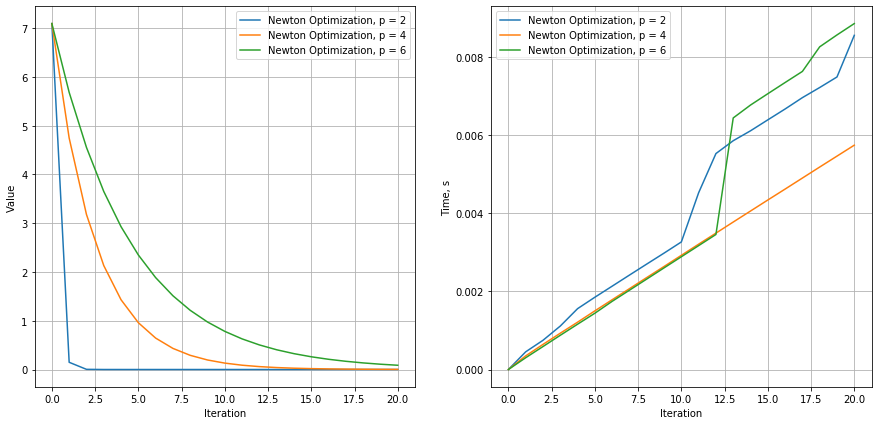

In [68]:
draw_plots([g_f_2_values_history_no, g_f_4_values_history_no, g_f_6_values_history_no],
           [times_history_no_2, times_history_no_4, times_history_no_6],
           ['Newton Optimization, p = 2', 'Newton Optimization, p = 4', 'Newton Optimization, p = 6'])

In [69]:
points_2, successes_2 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, f_2, x0, 3, size=10000, iterations=50)

In [70]:
points_4, successes_4 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, f_4, x0, 3, size=10000, iterations=50)

In [89]:
points_6, successes_6 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, f_6, x0, 3, size=10000, iterations=50)


In [90]:
print('Total 10000 trials')
print(f'p = 2, sigma=3, positive: {(np.array(successes_2) == 1).sum() / 10000}, negative: {(np.array(successes_2) == 0).sum() / 10000} ')
print(f'p = 4, sigma=3,  positive: {(np.array(successes_4) == 1).sum() / 10000}, negative: {(np.array(successes_4) == 0).sum() / 10000} ')
print(f'p = 6, sigma=3,  positive: {(np.array(successes_6) == 1).sum() / 10000}, negative: {(np.array(successes_6) == 0).sum() / 10000} ')


Total 10000 trials
p = 2, sigma=3, positive: 0.0971, negative: 0.0029 
p = 4, sigma=3,  positive: 0.0998, negative: 0.0002 
p = 6, sigma=3,  positive: 0.039, negative: 0.961 


# Conjugated Gradients

In [78]:
class ConjugateGradient():
    def __init__(self):
        pass
    
    def optimize(self, regression, x0, iterations=10, method='fletcher-reeves', default_step=0.01,
                line_search_iter=50, line_search_tolerance=10, verbose=False):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
        
        # conjugate direction
        d = -regression.grad(x)
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        
        if verbose:
            iter_in = tqdm(range(iterations))
        else:
            iter_in = range(iterations)
        for i in iter_in:
            # line search alpha
            #alpha = line_search(regression.forward, regression.grad, x, d, maxiter=100)[0]
            
            alpha = minimize_scalar(lambda l: regression.forward(x + l * d),
                                       bounds=(0, default_step), method='Brent',
                                       options={'maxiter':line_search_iter,
                                                'xtol': default_step / line_search_tolerance})
            alpha = alpha['x']
            if alpha == 0:
                if verbose:
                    print(f'Line search did not converge on iteration {i}, using default step')
                alpha = default_step / (i + 1)
                #return x_history, values_history, times_history
            
            # update x_k + 1
            x = x + alpha * d
            x_history.append(x)
            values_history.append(regression.forward(x))
            
            # compute g_k + 1
            g = regression.grad(x)
            grads_history.append(g)
            
            # update d_k + 1
            if method == 'fletcher-reeves':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = (g.T @ g) / (grads_history[-2].T @ grads_history[-2])
            elif method == 'polak-ribiere':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = ((g - grads_history[-2]).T @ g) / (grads_history[-2].T @ grads_history[-2])
            else:
                raise Exception(f'Unknown method: {method}')
            d = -g + beta * d
            
            # update times history
            times_history.append(time() - start)
        if verbose:
            print(f'Conjugate gradient converged on iteration {i}')
        return x_history, values_history, times_history

### Fletcher-Reeves

In [79]:
x_history_no_2, f_2_values_history_no, times_history_no_2 = ConjugateGradient().optimize(f_2, x0=x0, iterations=20, method='fletcher-reeves')
x_history_no_4, f_4_values_history_no, times_history_no_4 = ConjugateGradient().optimize(f_4, x0=x0, iterations=20, method='fletcher-reeves')
x_history_no_6, f_6_values_history_no, times_history_no_6 = ConjugateGradient().optimize(f_6, x0=x0, iterations=20, method='fletcher-reeves')


In [80]:
g_f_2_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_2]
g_f_4_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_4]
g_f_6_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_6]

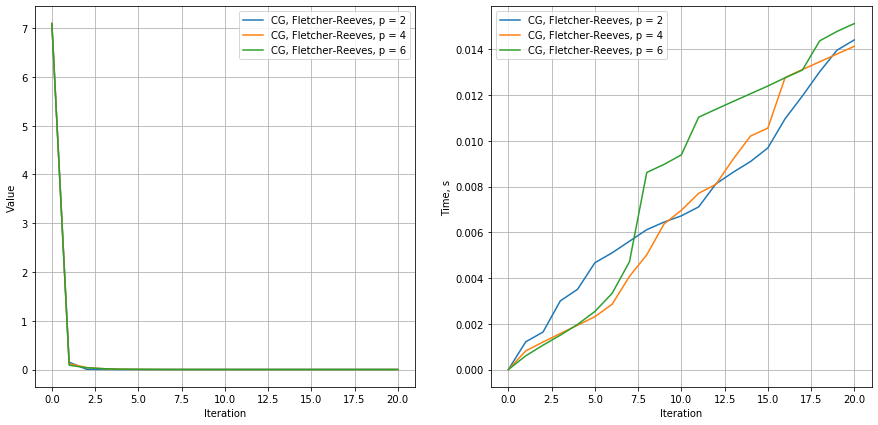

In [81]:
draw_plots([g_f_2_values_history_no, g_f_4_values_history_no, g_f_6_values_history_no],
           [times_history_no_2, times_history_no_4, times_history_no_6],
           ['CG, Fletcher-Reeves, p = 2', 'CG, Fletcher-Reeves, p = 4', 'CG, Fletcher-Reeves, p = 6'])

In [83]:
points_2, successes_2 = check_convergence_region(ConjugateGradient().optimize, f_2, x0, 3, size=1000, iterations=50)

In [84]:
points_4, successes_4 = check_convergence_region(ConjugateGradient().optimize, f_4, x0, 3, size=1000, iterations=50)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


In [87]:
points_6, successes_6 = check_convergence_region(ConjugateGradient().optimize, f_6, x0, 3, size=1000, iterations=50)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
/Users/dragonstone/o

In [88]:
print('Total 10000 trials')
print(f'p = 2, sigma=3, positive: {(np.array(successes_2) == 1).sum() / 1000}, negative: {(np.array(successes_2) == 0).sum() / 1000} ')
print(f'p = 4, sigma=3,  positive: {(np.array(successes_4) == 1).sum() / 1000}, negative: {(np.array(successes_4) == 0).sum() / 1000} ')
print(f'p = 6, sigma=3,  positive: {(np.array(successes_6) == 1).sum() / 1000}, negative: {(np.array(successes_6) == 0).sum() / 1000} ')

Total 10000 trials
p = 2, sigma=3, positive: 0.971, negative: 0.029 
p = 4, sigma=3,  positive: 0.998, negative: 0.002 
p = 6, sigma=3,  positive: 0.982, negative: 0.018 


### Polyak-Ribiere

In [91]:
x_history_no_2, f_2_values_history_no, times_history_no_2 = ConjugateGradient().optimize(f_2, x0=x0, iterations=20, method='polak-ribiere')
x_history_no_4, f_4_values_history_no, times_history_no_4 = ConjugateGradient().optimize(f_4, x0=x0, iterations=20, method='polak-ribiere')
x_history_no_6, f_6_values_history_no, times_history_no_6 = ConjugateGradient().optimize(f_6, x0=x0, iterations=20, method='polak-ribiere')

In [92]:
g_f_2_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_2]
g_f_4_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_4]
g_f_6_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_6]

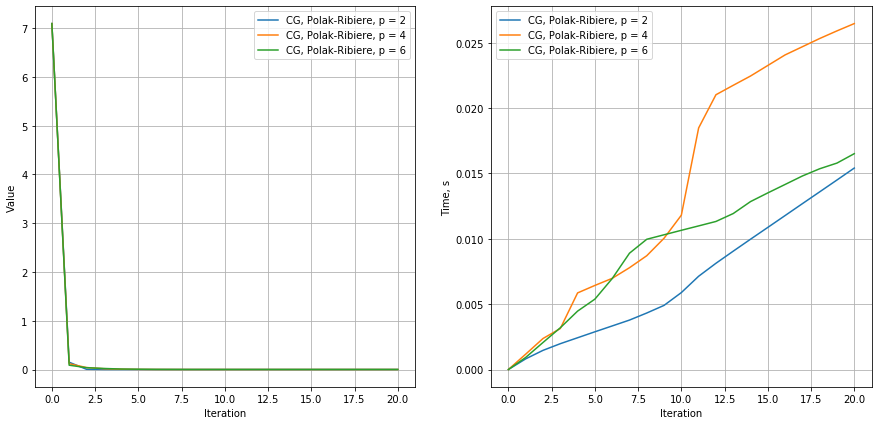

In [93]:
draw_plots([g_f_2_values_history_no, g_f_4_values_history_no, g_f_6_values_history_no],
           [times_history_no_2, times_history_no_4, times_history_no_6],
           ['CG, Polak-Ribiere, p = 2', 'CG, Polak-Ribiere, p = 4', 'CG, Polak-Ribiere, p = 6'])

In [94]:
points_2, successes_2 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), f_2,
                                                 x0, 3, size=1000, iterations=50)

In [95]:
points_4, successes_4 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'),
                                                 f_4, x0, 3, size=1000, iterations=50)

In [96]:
points_6, successes_6 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'),
                                                 f_6, x0, 3, size=1000, iterations=50)

In [97]:
print('Total 1000 trials')
print(f'p = 2, sigma=3, positive: {(np.array(successes_2) == 1).sum() / 1000}, negative: {(np.array(successes_2) == 0).sum() / 1000} ')
print(f'p = 4, sigma=3,  positive: {(np.array(successes_4) == 1).sum() / 1000}, negative: {(np.array(successes_4) == 0).sum() / 1000} ')
print(f'p = 6, sigma=3,  positive: {(np.array(successes_6) == 1).sum() / 1000}, negative: {(np.array(successes_6) == 0).sum() / 1000} ')

Total 1000 trials
p = 2, sigma=3, positive: 1.0, negative: 0.0 
p = 4, sigma=3,  positive: 1.0, negative: 0.0 
p = 6, sigma=3,  positive: 0.4, negative: 0.6 


# Modified Gauss Newton

In [114]:
from scipy.optimize import minimize_scalar, minimize

class ModifiedGaussNewton():
    def __init__(self):
        pass
    
    def optimize(self, equation, x0=None, iterations=10, minimize_iterations=500, tol=1e-10, initial_L=1, verbose=False):
        # random guess
        if x0 is None:
            x = np.random.rand(equation.A.shape[1])
        else: 
            x = x0

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [np.linalg.norm(equation.forward(x), ord=2)]#[regression.forward(x)]
        times_history = [0]
        L = initial_L
        
        if verbose:
            iter_in = tqdm(range(iterations))
        else:
            iter_in = range(iterations)
            
        for i in iter_in:
            L  = max(1 / 2 * L, initial_L)
            F = equation.forward(x)
            J = equation.grad(x)
            
            def objective(y):
                return np.linalg.norm(F + J.T @ (y - x), 2) + L / 2 * np.linalg.norm(y - x, 2) ** 2
                        
            m = minimize(objective, x, options={'maxiter':minimize_iterations})
            
            while not m['success']:
                if verbose:
                    print(f'Line search did not converge on iteration {i}, perturbing the x')
                L *= 2
                m = minimize(objective, x, options={'maxiter':minimize_iterations})
                
                if L > 10e+50:
                    return x_history, values_history, times_history
            
            x = m['x']
            
            x_history.append(x)
            values_history.append(np.linalg.norm(equation.forward(x), ord=2))           
            
            # update times history
            times_history.append(time() - start)
            if np.abs(values_history[-1] - values_history[-2]) <= tol:
                if verbose:
                    print(f'Modified Gauss Newton converged on iteration {i}')
                break
        return x_history, values_history, times_history

In [115]:
x_history, values_history, times_history = ModifiedGaussNewton().optimize(g, x0=x0, iterations=15, verbose=True)


Line search did not converge on iteration 0, perturbing the x
Line search did not converge on iteration 0, perturbing the x
Line search did not converge on iteration 1, perturbing the x
Line search did not converge on iteration 1, perturbing the x
Line search did not converge on iteration 1, perturbing the x
Line search did not converge on iteration 1, perturbing the x
Line search did not converge on iteration 2, perturbing the x
Line search did not converge on iteration 2, perturbing the x
Line search did not converge on iteration 2, perturbing the x
Line search did not converge on iteration 3, perturbing the x
Line search did not converge on iteration 3, perturbing the x
Line search did not converge on iteration 4, perturbing the x
Line search did not converge on iteration 4, perturbing the x
Line search did not converge on iteration 4, perturbing the x
Line search did not converge on iteration 5, perturbing the x
Line search did not converge on iteration 5, perturbing the x
Line sea

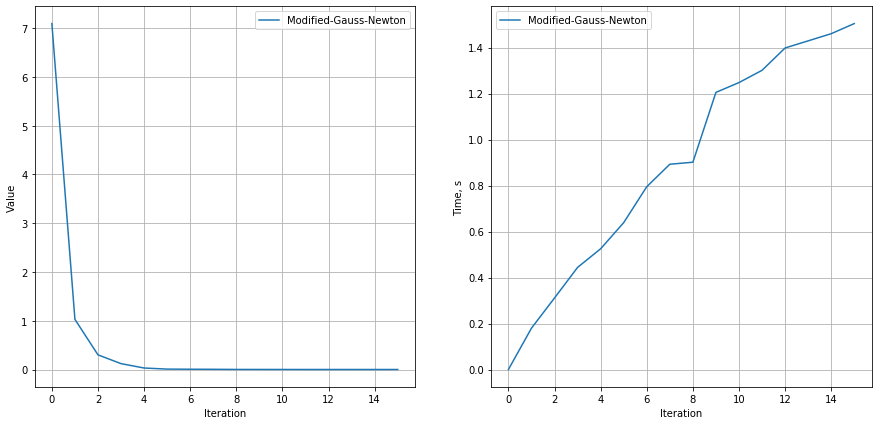

In [116]:
draw_plots([values_history],
           [times_history],
           ['Modified-Gauss-Newton'])

In [117]:
points, successes = check_convergence_region(ModifiedGaussNewton().optimize, g, x0, 3, size=100, iterations=15,
                                             optimization_problem=False)

In [118]:
print('Total 100 trials')
print(f'sigma=3, positive: {(np.array(successes) == 1).sum() / 100}, negative: {(np.array(successes) == 0).sum() / 100} ')

Total 100 trials
sigma=3, positive: 0.24, negative: 0.76 


# Accelerated Residuals

In [119]:
class AcceleratedResiduals():
    def __init__(self):
        pass
    
    def optimize(self, equation, x0=None, alpha=0.1, iterations=50, verbose=False, n=1, tol=1e-3 / np.sqrt(2), line_search_iter=100):
        # random guess
        if x0 is None:
            u = np.random.rand(function.A.shape[1])
        else: 
            u = x0

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        u_history = [u]
        values_history = [np.linalg.norm(equation.forward(u), ord=2)]
        times_history = [0]
        
        if verbose:
            pbar = tqdm(total=iterations)
        
        k = 0
        total_iters = 0
        alpha_k = alpha
        while (k <= iterations) and (total_iters <= iterations):
#             def objective_forward(alpha):
#                 return np.linalg.norm(equation.forward(u - alpha * equation.forward(u)))
            
#             alpha_k = minimize_scalar(objective_forward, bounds=(0, 1), method='bounded', options={'maxiter':line_search_iter})
#             alpha_k = alpha_k['x']
            if k == 0:
                v_k = u - alpha_k * equation.forward(u)
            else:
                beta_k = np.linalg.norm(equation.forward(u), ord=2) / np.linalg.norm(equation.forward(u_history[-2]), ord=2)
                v_k = u + beta_k * (u - u_history[-2]) - alpha_k * (1 + beta_k) * equation.forward(u)
            
            u = v_k - alpha_k * equation.forward(v_k)
            
            u_history.append(u)
            values_history.append(np.linalg.norm(equation.forward(u), ord=2))          
            times_history.append(time() - start)
            if np.linalg.norm(equation.forward(u), ord=2) <= tol:
                if verbose:
                    print(f'Accelerated residuals converged on iteration {total_iters}')
                for i in range(total_iters, iterations):
                    u_history.append(u_history[-1])
                    values_history.append(values_history[-1])
                    times_history.append(times_history[-1])
                break
            if k > n and values_history[-1] > values_history[-1 - n]:
                u = x_history[-2]
                k = 0
            if verbose:
                pbar.update(1)
            total_iters += 1
            
            if total_iters > iterations:
                break
        return u_history, values_history, times_history

In [121]:
x_history, values_history, times_history = AcceleratedResiduals().optimize(g, x0, iterations=1000, alpha=1e-2, verbose=True)

Accelerated residuals converged on iteration 94


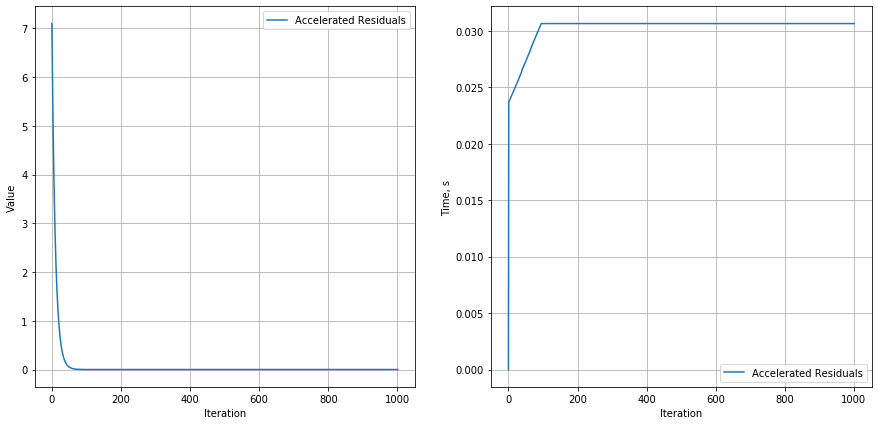

In [122]:
draw_plots([values_history],
           [times_history],
           ['Accelerated Residuals'])

In [125]:
points, successes = check_convergence_region(AcceleratedResiduals().optimize, g,
                                                 x0, 3, size=10000, iterations=100, optimization_problem=False)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


In [127]:
print('Total 10000 trials')
print(f'sigma=3, positive: {(np.array(successes_2) == 1).sum() / 10000}, negative: {(np.array(successes_2) == 0).sum() / 10000} ')

Total 10000 trials
sigma=3, positive: 0.1, negative: 0.0 


# AcceleratedResiduals Grad

In [129]:
class AcceleratedResidualsGrad():
    def __init__(self):
        pass
    
    def optimize(self, function, x0=None, alpha=0.1, iterations=50, verbose=False, n=1, tol=1e-3 / np.sqrt(2), line_search_iter=100):
        # random guess
        if x0 is None:
            u = np.random.rand(function.A.shape[1])
        else: 
            u = x0

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        u_history = [u]
        values_history = [function.forward(u)]
        times_history = [0]
        
        if verbose:
            pbar = tqdm(total=iterations)
        
        k = 0
        total_iters = 0
        alpha_k = alpha
        while (k <= iterations) and (total_iters <= iterations):
#             def objective_forward(alpha):
#                 return np.linalg.norm(equation.forward(u - alpha * equation.forward(u)))
            
#             alpha_k = minimize_scalar(objective_forward, bounds=(0, 1), method='bounded', options={'maxiter':line_search_iter})
#             alpha_k = alpha_k['x']
            if k == 0:
                v_k = u - alpha_k * function.grad(u)
            else:
                beta_k = np.linalg.norm(function.grad(u), ord=2) / np.linalg.norm(function.grad(u_history[-2]), ord=2)
                v_k = u + beta_k * (u - u_history[-2]) - alpha_k * (1 + beta_k) * function.grad(u)
            
            u = v_k - alpha_k * function.grad(v_k)
            
            u_history.append(u)
            values_history.append(function.forward(u))           
            times_history.append(time() - start)
            if np.linalg.norm(function._g.forward(u)) <= tol:
                if verbose:
                    print(f'Accelerated residuals converged on iteration {total_iters}')
                for i in range(total_iters, iterations):
                    u_history.append(u_history[-1])
                    values_history.append(values_history[-1])
                    times_history.append(times_history[-1])
                break
            if k > n and values_history[-1] > values_history[-1 - n]:
                u = x_history[-2]
                k = 0
            if verbose:
                pbar.update(1)
            total_iters += 1
            
            if total_iters > iterations:
                break
        return u_history, values_history, times_history

In [171]:
x_history_no_2, f_2_values_history_no, times_history_no_2 = AcceleratedResidualsGrad().optimize(f_2, x0, iterations=2000, alpha=1e-2, verbose=True)
x_history_no_4, f_4_values_history_no, times_history_no_4 = AcceleratedResidualsGrad().optimize(f_4, x0, iterations=2000, alpha=1.5e-3, verbose=True)
x_history_no_6, f_6_values_history_no, times_history_no_6 = AcceleratedResidualsGrad().optimize(f_6, x0, iterations=2000, alpha=1.5e-4, verbose=True)


Accelerated residuals converged on iteration 7


In [172]:
g_f_2_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_2]
g_f_4_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_4]
g_f_6_values_history_no = [np.linalg.norm(g.forward(x), ord=2) for x in x_history_no_6]

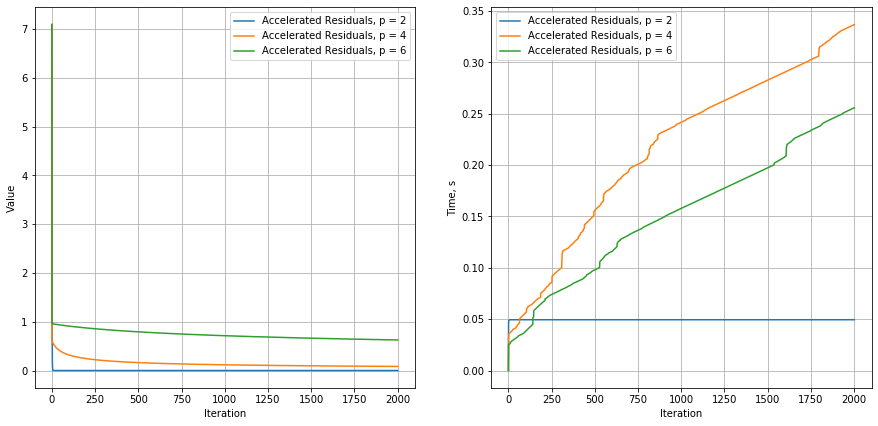

In [173]:
draw_plots([g_f_2_values_history_no, g_f_4_values_history_no, g_f_6_values_history_no],
           [times_history_no_2, times_history_no_4, times_history_no_6],
           ['Accelerated Residuals, p = 2', 'Accelerated Residuals, p = 4', 'Accelerated Residuals, p = 6'])

In [174]:
points_2, successes_2 = check_convergence_region(AcceleratedResidualsGrad().optimize, f_2,
                                                 x0, 3, size=1000, iterations=100)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app


In [175]:
points_4, successes_4 = check_convergence_region(AcceleratedResidualsGrad().optimize,
                                                 f_4, x0, 3, size=1000, iterations=100)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/Users/dragonstone/opt/ana

In [176]:
points_6, successes_6 = check_convergence_region(AcceleratedResidualsGrad().optimize,
                                                 f_6, x0, 3, size=1000, iterations=100)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app


In [177]:
print('Total 1000 trials')
print(f'p = 2, sigma=3, positive: {(np.array(successes_2) == 1).sum() / 1000}, negative: {(np.array(successes_2) == 0).sum() / 1000} ')
print(f'p = 4, sigma=3,  positive: {(np.array(successes_4) == 1).sum() / 1000}, negative: {(np.array(successes_4) == 0).sum() / 1000} ')
print(f'p = 6, sigma=3,  positive: {(np.array(successes_6) == 1).sum() / 1000}, negative: {(np.array(successes_6) == 0).sum() / 1000} ')

Total 1000 trials
p = 2, sigma=3, positive: 0.0, negative: 1.0 
p = 4, sigma=3,  positive: 0.0, negative: 1.0 
p = 6, sigma=3,  positive: 0.0, negative: 1.0 
